In [1]:
import tensorflow as tf
import polars as pl
import utils
utils.mount_src()

DATA_PATH = "E:/30-39 Estudos/36 Mestrado/36.03 Deep learning para computação visual/Projeto/flickr_scraper/images"
METADATA = DATA_PATH + "/metadata.csv"

In [2]:
import filetype

def is_gif(filename: str) -> bool:
    guess = filetype.guess(filename)
    return guess.mime == "image/gif"


def filter_out_gifs(df: pl.DataFrame) -> pl.DataFrame:
    original_columns = df.columns
    df = df.with_columns(
    (
        DATA_PATH + "/" + pl.col("year").cast(pl.String) + "/" + pl.col("id").cast(pl.String) + ".jpg"
    ).alias("filepath")
    )
    df = df.with_columns(
        (
            df["filepath"].map_elements(is_gif, return_dtype=pl.Boolean)
        ).alias("is_gif")
    )
    df = df.filter(~pl.col("is_gif"))
    return df.select(original_columns)

In [3]:
df = pl.read_csv(METADATA)
df = filter_out_gifs(df)
df

id,latitude,longitude,url,year
i64,f64,f64,str,i64
54135607231,50.817777,6.892222,"""https://live.staticflickr.com/…",1900
54135607226,50.817777,6.892222,"""https://live.staticflickr.com/…",1900
54126804576,48.866591,2.34005,"""https://live.staticflickr.com/…",1900
54125949837,48.86338,2.3437,"""https://live.staticflickr.com/…",1900
54126792236,48.86338,2.343697,"""https://live.staticflickr.com/…",1900
…,…,…,…,…
51996976701,41.8956,12.472196,"""https://live.staticflickr.com/…",1962
52614844417,51.206143,-3.461143,"""https://live.staticflickr.com/…",1962
54213982517,43.081858,-79.078531,"""https://live.staticflickr.com/…",1962


In [4]:
paths = DATA_PATH + "/" + df["year"].cast(pl.String) + "/" + df["id"].cast(pl.String) + ".jpg"
paths = paths.to_numpy()
years = df["year"].to_numpy()
lats = df["latitude"].to_numpy()
lons = df["longitude"].to_numpy()

In [5]:
def load_image_and_label(path: str, year: int, lat: float, lon: float, image_shape=(224, 224)):
    try:
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, image_shape) / 255.0
    except tf.errors.InvalidArgumentError as e:
        tf.print(f"Error on path {path}")
        raise e
    return img, {
        "year": year,
        "lat": lat,
        "lon": lon
    }

In [6]:
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

dataset = tf.data.Dataset.from_tensor_slices((paths, years, lats, lons))
dataset = dataset.map(lambda path, year, lat, lon: load_image_and_label(path, year, lat, lon))

batch_size = 32
dataset = dataset.shuffle(buffer_size=len(paths)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [7]:
def create_model():
    input_img = tf.keras.Input(shape=(224, 224, 3), name="image")
    x = tf.keras.layers.Conv2D(16, (3, 3), activation="relu")(input_img)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(32, activation="relu")(x)

    output_year = tf.keras.layers.Dense(1, name="year")(x)
    output_lat = tf.keras.layers.Dense(1, name="lat")(x)
    output_lon = tf.keras.layers.Dense(1, name="lon")(x)

    return tf.keras.Model(inputs=input_img, outputs={"year": output_year, "lat": output_lat, "lon": output_lon})


In [8]:
model = create_model()
model.build(input_shape=(None, 224, 224, 3))
model.compile(
    optimizer="adam",
    loss={"year": "mse", "lat": "mse", "lon": "mse"},
    metrics={"year": "mae", "lat": "mae", "lon": "mae"}
)

In [9]:
history = model.fit(dataset, epochs=5)

Epoch 1/5


1310/1310 ━━━━━━━━━━━━━━━━━━━━ 282s 139ms/step - lat_loss: 813.6372 - lat_mae: 18.7508 - lon_loss: 5313.5474 - lon_mae: 54.8607 - loss: 116865.2031 - year_loss: 110737.9766 - year_mae: 147.9023
Epoch 2/5
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 496s 188ms/step - lat_loss: 579.0217 - lat_mae: 15.5423 - lon_loss: 4840.1436 - lon_mae: 52.0145 - loss: 6028.1968 - year_loss: 609.0284 - year_mae: 19.9456
Epoch 3/5
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 504s 178ms/step - lat_loss: 552.9476 - lat_mae: 15.0116 - lon_loss: 4611.9893 - lon_mae: 50.6921 - loss: 5735.1836 - year_loss: 570.2466 - year_mae: 19.1991
Epoch 4/5
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 414s 134ms/step - lat_loss: 518.1146 - lat_mae: 14.4996 - lon_loss: 4160.4512 - lon_mae: 48.0421 - loss: 5179.1055 - year_loss: 500.5416 - year_mae: 17.9918
Epoch 5/5
1310/1310 ━━━━━━━━━━━━━━━━━━━━ 605s 279ms/step - lat_loss: 489.2910 - lat_mae: 14.3800 - lon_loss: 3834.4365 - lon_mae: 46.2893 - loss: 4744.0967 - year_loss: 420.3711 - year_mae: 16.5718


In [13]:
history.history

{'lat_loss': [649.1912231445312,
  578.712646484375,
  549.6866455078125,
  519.1322631835938,
  489.8235168457031],
 'lat_mae': [16.463146209716797,
  15.55965518951416,
  15.011953353881836,
  14.634359359741211,
  14.427680015563965],
 'lon_loss': [5103.025390625,
  4790.2041015625,
  4500.09619140625,
  4124.40771484375,
  3771.2392578125],
 'lon_mae': [53.599056243896484,
  51.816802978515625,
  49.97113800048828,
  47.73397445678711,
  45.800262451171875],
 'loss': [28847.140625,
  5972.23193359375,
  5648.80908203125,
  5152.47314453125,
  4698.1650390625],
 'year_loss': [23094.875,
  603.3106079101562,
  599.01953125,
  508.9388122558594,
  437.10211181640625],
 'year_mae': [55.62598419189453,
  19.838022232055664,
  19.67279624938965,
  18.162559509277344,
  16.861398696899414]}

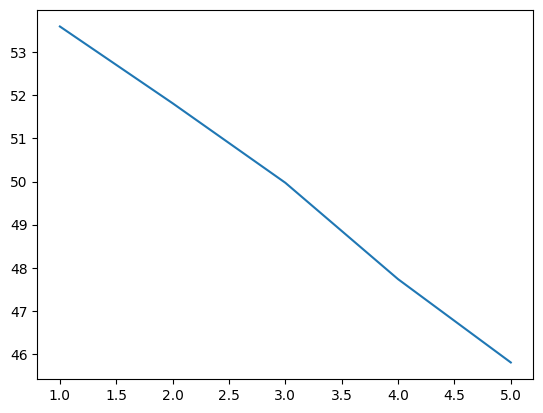

In [16]:
import matplotlib.pyplot as plt

epochs = [i for i in range(1, 6)]

plt.plot(epochs, history.history["lon_mae"])

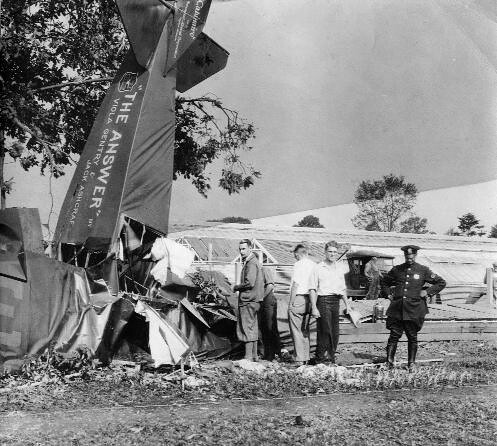

In [21]:
from tensorflow.keras.utils import img_to_array, load_img

example = DATA_PATH + "/1929/" + "2123423918.jpg"
img = load_img(example)
img

In [19]:
metadata_for_year = pl.read_csv(DATA_PATH + "/1929/metadata.csv")
labels = metadata_for_year.filter(pl.col("id") == 2123423918)
labels

id,latitude,longitude,url,year
i64,f64,f64,str,i64
2123423918,40.763576,-73.599214,"""https://live.staticflickr.com/…",1929


In [24]:
def load_and_preprocess_image(path, image_shape=(224, 224)):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, image_shape) / 255.0
    return img

img = load_and_preprocess_image(example)
img_batch = tf.expand_dims(img, axis=0)
model.predict(img_batch)

ValueError: Input 0 of layer "functional" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(32, 224, 3)